In [20]:
# Imports

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from scipy import stats
import statsmodels.api as sm

import sys
import os
sys.path.append(os.path.abspath('..'))
from backtest_helpers import cross_section_regression, compute_betas, set_date_index, separate

### Data

In [21]:
# Preprocess data
daily_prices_df = pd.read_csv('sp500_price_data.csv')
daily_prices_df = set_date_index(daily_prices_df, date_column_name='date', date_format_str='%Y-%m-%d')

def convert_monthly(price_df):
    monthly_prices = price_df.resample('ME').last()
    monthly_returns = monthly_prices.pct_change()
    monthly_returns = monthly_returns.iloc[1:]  # Drop first NaN row
    return monthly_returns

# Convert to monthly returns
monthly_returns = convert_monthly(daily_prices_df)
# reindex monthly returns to beginning of month
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp()

print("Number with returns at beginning: ", monthly_returns.iloc[0, :].notna().sum())

# Read in the risk free rate
ff_returns = pd.read_excel('ff_factor_returns.xls')
ff_returns = set_date_index(ff_returns, date_column_name='Unnamed: 0', date_format_str='%Y%m')
ff_returns /= 100
risk_free_series = ff_returns['RF']

display(monthly_returns.head())
display(risk_free_series.head())

/var/folders/xf/qngl6nps4vdf66h_qdpl228w0000gn/T/ipykernel_30935/222360212.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = monthly_prices.pct_change()


Number with returns at beginning:  233


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1990-02-01,NaN,0.000000,NaN,NaN,-0.013462,NaN,NaN,0.287234,0.065574,0.050000,...,NaN,0.000000,NaN,-0.020134,0.000000,NaN,NaN,NaN,NaN,NaN
1990-03-01,NaN,0.183824,NaN,NaN,0.025341,NaN,NaN,0.256198,0.015385,0.083333,...,NaN,0.061538,NaN,-0.003425,-0.018617,NaN,NaN,NaN,NaN,NaN
1990-04-01,NaN,-0.021739,NaN,NaN,0.015209,NaN,NaN,0.006579,-0.181818,0.032967,...,NaN,-0.053140,NaN,-0.079038,-0.018970,NaN,NaN,NaN,NaN,NaN
1990-05-01,NaN,0.047619,NaN,NaN,0.121723,NaN,NaN,-0.068627,0.148148,0.127660,...,NaN,0.117347,NaN,0.070896,0.060773,NaN,NaN,NaN,NaN,NaN
1990-06-01,NaN,0.084848,NaN,NaN,-0.452421,NaN,NaN,0.031579,-0.032258,-0.033019,...,NaN,-0.068493,NaN,0.006969,-0.002604,NaN,NaN,NaN,NaN,NaN


date
1963-07-01    0.0027
1963-08-01    0.0025
1963-09-01    0.0027
1963-10-01    0.0029
1963-11-01    0.0027
Name: RF, dtype: float64

### Creating Design Matrix fo Regressions

In [22]:
# Method to generate characterstics (covariates) and all_returns data (response)
def lookforward_reg_data(monthly_returns, lookback=12, lookforward=1, skip_recent=1):
    '''
    args:
        monthly_returns: df of monthly returns data
        lookback: number of months to compute past-return covariate
        lookforward: response variable (trying to measure signal decay)
    does:
        Generates input data (covariates, response) forward-looking returns on the past-return 
        as determined by lookback and skip_recent. The goal is to examine the decay
        of the predictive power of past returns further into the future. This could
        help inform holding period. Note that the dates will be indexed relative to 
        "today," which is the date at which past-returns are measured 
    returns:
        all_returns: df of forward-looking returns
        char_dict: dictionary of past-return characteristics
    '''
    all_return_list = []
    past_return_list = []
    char_dict = {}

    start_idx = lookback + skip_recent
    end_idx = len(monthly_returns) - lookforward + 1

    # NOTE: rolling would probably be faster
    for i in range(start_idx, end_idx):
        # Get the past returns across tickers
        past_return_df = monthly_returns.iloc[i - lookback:i - skip_recent, :]
        past_212_returns = (1 + past_return_df).prod() - 1
        past_return_list.append(past_212_returns)   

        future_returns = monthly_returns.iloc[i + lookforward - 1, :]
        all_return_list.append(future_returns)

    # Constructing the dataframes
    all_returns = pd.DataFrame(all_return_list, index=monthly_returns.index[start_idx:end_idx])
    past_returns = pd.DataFrame(past_return_list, index=monthly_returns.index[start_idx:end_idx])
    char_dict['past_212'] = past_returns
    return all_returns, char_dict



### Regressions of different look-forward periods on 212 return, No Risk Factors

In [33]:
# Try different look-forward periods
lookforward = [i for i in range(1, 36)]

gamma_mean_reg1 = []
gamma_se_reg1 = []
gamma_t_reg1 = []
r2_means_reg1 = []

for lf in lookforward:
    all_returns, char_dict = lookforward_reg_data(monthly_returns, lookback=12, 
                                                  lookforward=lf, skip_recent=1)
    
    # Align the risk-free rate, all_returns, and char_dict
    common_index = all_returns.index.intersection(risk_free_series.index)
    risk_free_aligned = risk_free_series.loc[common_index]
    all_returns_aligned = all_returns.loc[common_index, :]
    all_returns_excess = all_returns_aligned.subtract(risk_free_aligned, axis=0)
    char_dict['past_212'] = char_dict['past_212'].loc[common_index, :]
    
    gammas, fm_mean, fm_se, fm_t, r2_list = cross_section_regression(all_returns_excess, pd.DataFrame(),
                                                                     char_dict, risk_free_aligned)
    gamma_mean_reg1.append(fm_mean.loc['gamma_past_212'])
    gamma_se_reg1.append(fm_se.loc['gamma_past_212'])
    gamma_t_reg1.append(fm_t.loc['gamma_past_212'])
    r2_means_reg1.append(np.mean(r2_list))
    

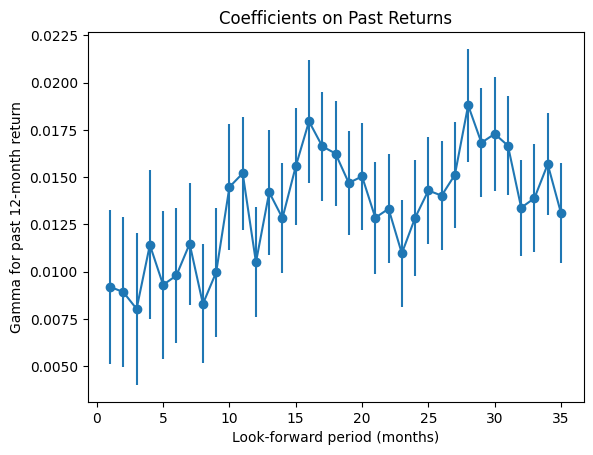

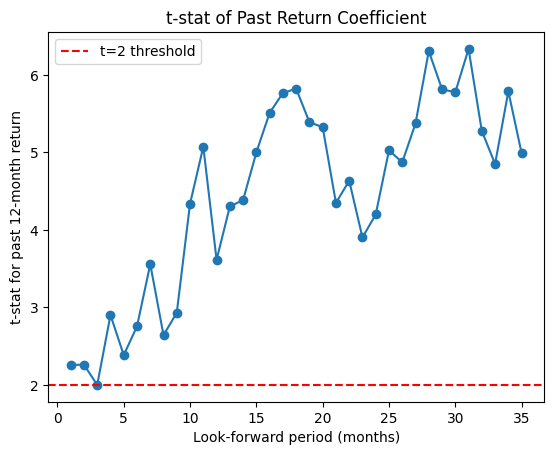

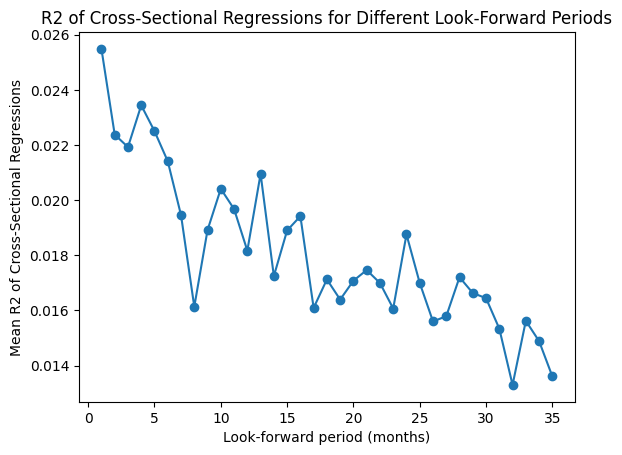

In [24]:
# plot the gammas
import matplotlib.pyplot as plt
plt.errorbar(lookforward, gamma_mean_reg1, yerr=gamma_se_reg1, fmt='-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('Gamma for past 12-month return')
plt.title('Coefficients on Past Returns')
plt.show()

# Plot the t-stats
plt.plot(lookforward, gamma_t_reg1, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat for past 12-month return')
plt.title('t-stat of Past Return Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the R2
plt.plot(lookforward, r2_means_reg1, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('Mean R2 of Cross-Sectional Regressions')
plt.title('R2 of Cross-Sectional Regressions for Different Look-Forward Periods')
plt.show()

### Regressions of different look-forward periods on 212 Past Return, + RmRf, HML, UMD

In [25]:
# NOTE: ignoring SMB because SP is all large cap

# Compute betas

# Get intersection between monthly returns and ff returns
common_index = monthly_returns.index.intersection(ff_returns.index)
ff_returns_aligned = ff_returns.reindex(common_index)
risk_free_aligned = ff_returns_aligned['RF']
monthly_returns_aligned = monthly_returns.reindex(common_index)

# Need to cut out the tickers that are limited to after 2017 #
# (factor data only up to here). Drop columns w/ less than 10 yrs
monthly_returns_aligned = monthly_returns_aligned.loc[:, monthly_returns_aligned.notna().sum() >= 120]
print("New universe size: ", monthly_returns_aligned.shape[1])

# display(monthly_returns_aligned.subtract(risk_free_aligned, axis=0))
# display(ff_returns_aligned)

# Compute betas on market, HML, and SMB
betas, _, alphas, _ = compute_betas(monthly_returns_aligned.sub(risk_free_aligned, axis=0), 
                                      ff_returns_aligned[["Mkt-RF", "HML", "UMD"]])


# Same as above regression, but no SMB
gamma_mean_reg2 = []
gamma_se_reg2 = []

# Collect t-stats for each factor
gamma_pr_t_reg2 = []
gamma_hml_t_reg2 = []
gamma_mkt_t_reg2 = []
gamma_umd_t_reg2 = []

r2_means_reg2 = []

for lf in lookforward:
    all_returns, char_dict = lookforward_reg_data(monthly_returns, lookback=12, 
                                                  lookforward=lf, skip_recent=1)
    # Align the risk-free rate, all_returns, and char_dict
    common_index = all_returns.index.intersection(risk_free_series.index)
    risk_free_aligned = risk_free_series.reindex(common_index)
    all_returns_aligned = all_returns.reindex(common_index)
    all_returns_excess = all_returns_aligned.subtract(risk_free_aligned, axis=0)
    char_dict['past_212'] = char_dict['past_212'].loc[common_index, :]

    # NOTE: subsetting to our new universe
    all_returns_excess = all_returns_excess.loc[:, monthly_returns_aligned.columns]
    char_dict['past_212'] = char_dict['past_212'].loc[:, monthly_returns_aligned.columns]

    gammas, fm_mean, fm_se, fm_t, r2_list = cross_section_regression(all_returns_excess, betas,
                                                                     char_dict, risk_free_aligned)
    gamma_mean_reg2.append(fm_mean.loc['gamma_past_212'])
    gamma_se_reg2.append(fm_se.loc['gamma_past_212'])

    # display(fm_t)

    gamma_pr_t_reg2.append(fm_t.loc['gamma_past_212'])
    gamma_hml_t_reg2.append(fm_t.loc['gamma_Beta on HML'])
    gamma_mkt_t_reg2.append(fm_t.loc['gamma_Beta on Mkt-RF'])
    gamma_umd_t_reg2.append(fm_t.loc['gamma_Beta on UMD'])
    
    r2_means_reg2.append(np.mean(r2_list))
    

New universe size:  408


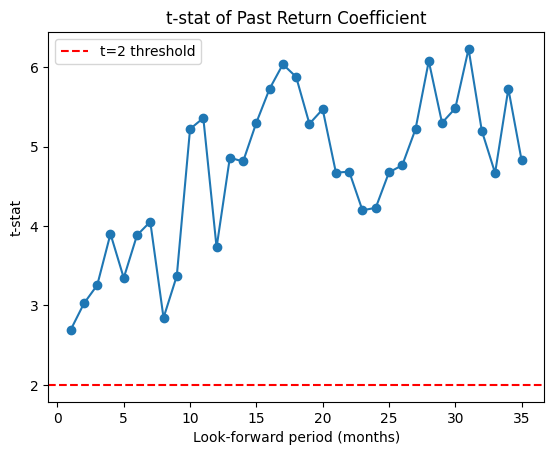

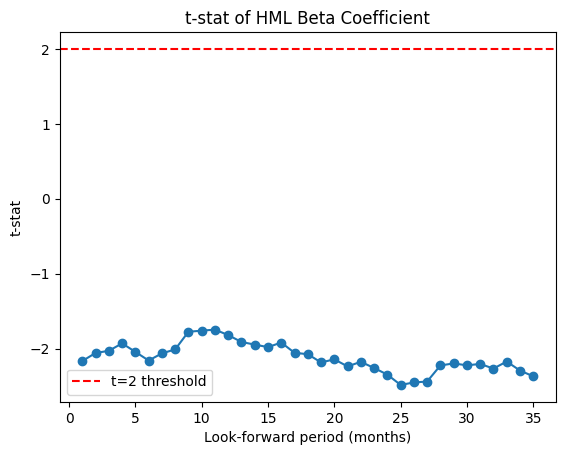

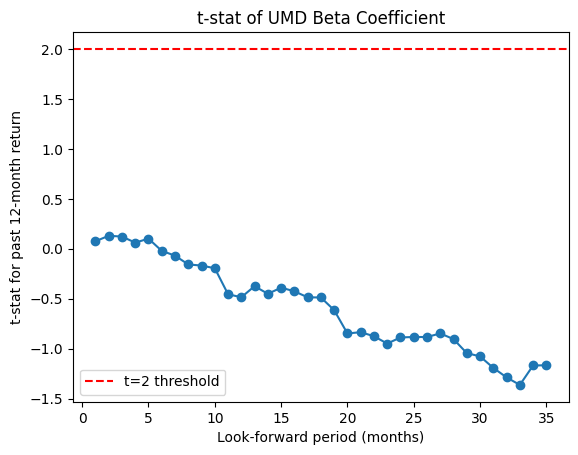

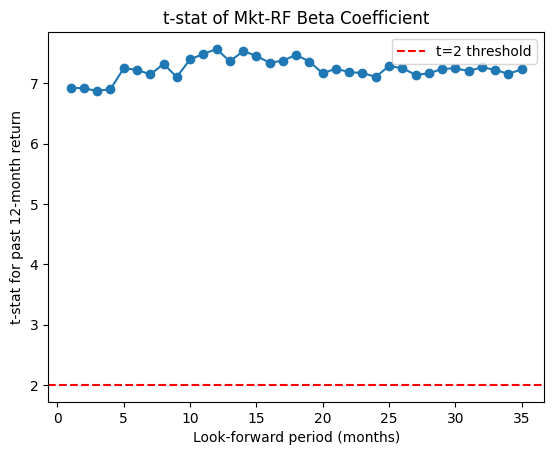

In [26]:
# # plot the gammas
# import matplotlib.pyplot as plt
# plt.errorbar(lookforward, gamma_mean_reg2, yerr=gamma_se_reg2, fmt='-o')
# plt.xlabel('Look-forward period (months)')
# plt.ylabel('Gamma for past 12-month return')
# plt.title('Coefficients on Past Returns')
# plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_pr_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of Past Return Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_hml_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of HML Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_umd_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat for past 12-month return')
plt.title('t-stat of UMD Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_mkt_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat for past 12-month return')
plt.title('t-stat of Mkt-RF Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()



# # Plot the R2
# plt.plot(lookforward, r2_means_reg2, '-o')
# plt.xlabel('Look-forward period (months)')
# plt.ylabel('Mean R2 of Cross-Sectional Regressions')
# plt.title('R2 of Past Return Coefficient')
# plt.show()

### Repeat Regressions, but using industry portfolios

In [29]:
industry_returns = pd.read_excel('../data/value_weighted_industries.xls', skiprows=3)
industry_returns = set_date_index(industry_returns, date_column_name='Unnamed: 0', date_format_str='%Y%m')
industry_returns /= 100

FileNotFoundError: [Errno 2] No such file or directory: '../data/value_weighted_industries.xls'

In [32]:
# Compute betas

# Get intersection between monthly returns and ff returns
common_index = industry_returns.index.intersection(ff_returns.index)
ff_returns_aligned = ff_returns.reindex(common_index)
risk_free_aligned = ff_returns_aligned['RF']
industry_returns_aligned = industry_returns.reindex(common_index)

# Need to cut out the tickers that are limited to after 2017 #
# (factor data only up to here). Drop columns w/ less than 10 yrs
industry_returns_aligned = industry_returns_aligned.loc[:, industry_returns_aligned.notna().sum() >= 120]
print("New universe size: ", industry_returns_aligned.shape[1])

# display(industry_returns_aligned.subtract(risk_free_aligned, axis=0))
# display(ff_returns_aligned)

# Compute betas on market, HML, and SMB
betas, _, alphas, _ = compute_betas(industry_returns_aligned.sub(risk_free_aligned, axis=0), 
                                      ff_returns_aligned[["Mkt-RF", "HML", "UMD"]])


# Same as above regression, but no SMB
gamma_mean_reg2 = []
gamma_se_reg2 = []

# Collect t-stats for each factor
gamma_pr_t_reg2 = []
gamma_hml_t_reg2 = []
gamma_mkt_t_reg2 = []
gamma_umd_t_reg2 = []

r2_means_reg2 = []

for lf in lookforward:
    all_returns, char_dict = lookforward_reg_data(industry_returns, lookback=12, 
                                                  lookforward=lf, skip_recent=1)
    # Align the risk-free rate, all_returns, and char_dict
    common_index = all_returns.index.intersection(risk_free_series.index)
    risk_free_aligned = risk_free_series.reindex(common_index)
    all_returns_aligned = all_returns.reindex(common_index)
    all_returns_excess = all_returns_aligned.subtract(risk_free_aligned, axis=0)
    char_dict['past_212'] = char_dict['past_212'].loc[common_index, :]

    # NOTE: subsetting to our new universe
    all_returns_excess = all_returns_excess.loc[:, industry_returns_aligned.columns]
    char_dict['past_212'] = char_dict['past_212'].loc[:, industry_returns_aligned.columns]

    gammas, fm_mean, fm_se, fm_t, r2_list = cross_section_regression(all_returns_excess, betas,
                                                                     char_dict, risk_free_aligned)
    gamma_mean_reg2.append(fm_mean.loc['gamma_past_212'])
    gamma_se_reg2.append(fm_se.loc['gamma_past_212'])

    # display(fm_t)

    gamma_pr_t_reg2.append(fm_t.loc['gamma_past_212'])
    gamma_hml_t_reg2.append(fm_t.loc['gamma_Beta on HML'])
    gamma_mkt_t_reg2.append(fm_t.loc['gamma_Beta on Mkt-RF'])
    gamma_umd_t_reg2.append(fm_t.loc['gamma_Beta on UMD'])
    
    r2_means_reg2.append(np.mean(r2_list))
    

NameError: name 'industry_returns' is not defined

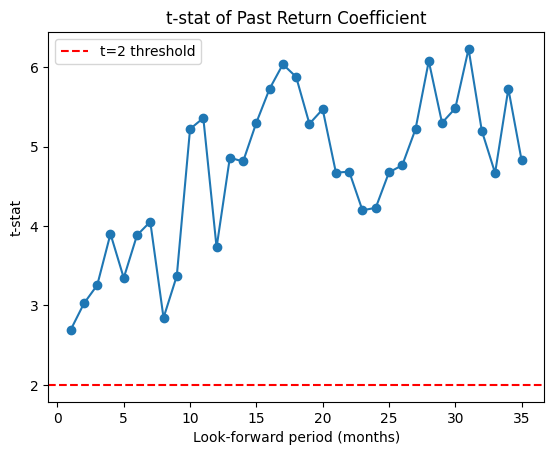

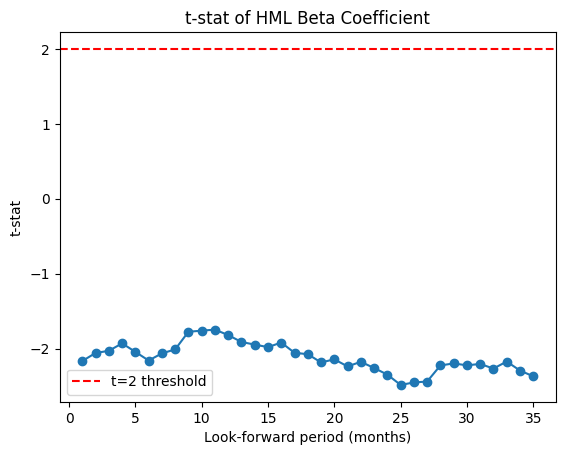

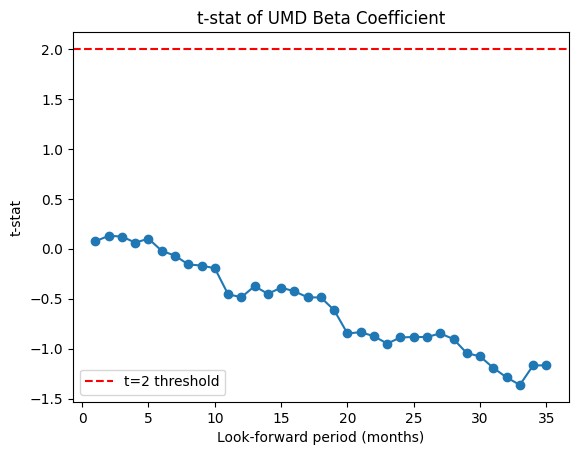

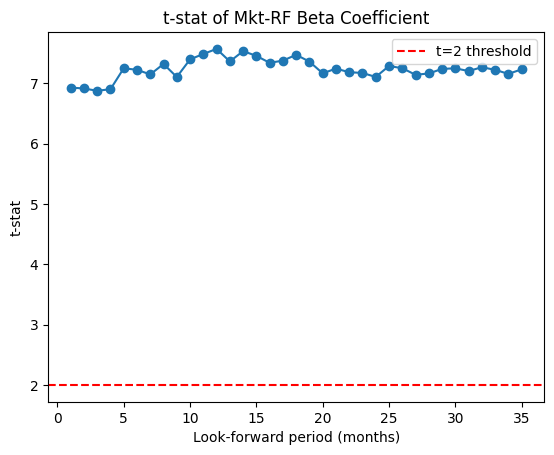

In [28]:
# Plot the t-stats of gammas
plt.plot(lookforward, gamma_pr_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of Past Return Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_hml_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of HML Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_umd_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of UMD Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

# Plot the t-stats of gammas
plt.plot(lookforward, gamma_mkt_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of Mkt-RF Beta Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

### Regressing Industry Portfolio Returns only on past-returns

In [ ]:
# Same as above regression, but no SMB
gamma_mean_reg2 = []
gamma_se_reg2 = []

# Collect t-stats for each factor
gamma_pr_t_reg2 = []

r2_means_reg2 = []

for lf in lookforward:
    all_returns, char_dict = lookforward_reg_data(industry_returns, lookback=12, 
                                                  lookforward=lf, skip_recent=1)
    # Align the risk-free rate, all_returns, and char_dict
    common_index = all_returns.index.intersection(risk_free_series.index)
    risk_free_aligned = risk_free_series.reindex(common_index)
    all_returns_aligned = all_returns.reindex(common_index)
    all_returns_excess = all_returns_aligned.subtract(risk_free_aligned, axis=0)
    char_dict['past_212'] = char_dict['past_212'].loc[common_index, :]

    # NOTE: subsetting to our new universe
    all_returns_excess = all_returns_excess.loc[:, industry_returns_aligned.columns]
    char_dict['past_212'] = char_dict['past_212'].loc[:, industry_returns_aligned.columns]

    gammas, fm_mean, fm_se, fm_t, r2_list = cross_section_regression(all_returns_excess, pd.DataFrame(),
                                                                     char_dict, risk_free_aligned)
    gamma_mean_reg2.append(fm_mean.loc['gamma_past_212'])
    gamma_se_reg2.append(fm_se.loc['gamma_past_212'])

    # display(fm_mean)

    # display(fm_t)

    gamma_pr_t_reg2.append(fm_t.loc['gamma_past_212'])
    
    r2_means_reg2.append(np.mean(r2_list))
    

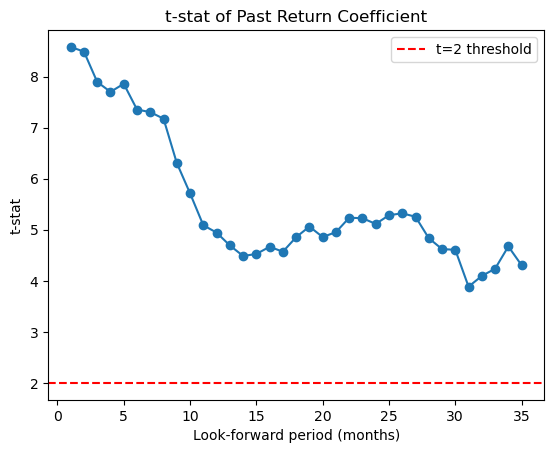

In [ ]:
# Plot the t-stats of gammas
plt.plot(lookforward, gamma_pr_t_reg2, '-o')
plt.xlabel('Look-forward period (months)')
plt.ylabel('t-stat')
plt.title('t-stat of Past Return Coefficient')
plt.axhline(y=2, color='r', linestyle='--', label='t=2 threshold')
plt.legend()
plt.show()

### NOTES from Moskowitz Lecture on TSMOM

1. Maybe not as much trading difference between CSMOM and TSMOM as one would expect. Would not necessarily be long only top decile for CSMOM
2. Even if you think about turnover of sign, probably not that big of a difference
3. In terms of ML applications for weighting together different lookback signals, both he and Brian Kelly have done some research on it (find papers)
4. Possible to do ML to learn the optimal weights between different lookbacks: nothing inherently special about a 12mo lookback. What you'll probably find is some additional edge over the traditional TSMOM
5. Would be interesting to see the effects of volatility-adjusted equal weight per asset instead of doing it on each asset class. Note that AQR does it for each asset class

### JT 93 TSMOM Code

In [52]:
# jt93 code WITHOUT deciles strategy
def jt93_old(monthly_returns, J=12, K=6, skip_recent=1):
    """
    JT93 overlapping portfolio strategy for TSMOM
    
    Key idea: Hold K portfolios simultaneously, each formed at different times
    Return at time t = average of K active portfolios
    
    Args:
        monthly_returns: DataFrame of monthly returns
        J: formation period (lookback) in months
        K: holding period (number of overlapping portfolios)
        skip_recent: months to skip in signal (default 1)
    
    Returns:
        results_df: DataFrame with strategy returns
    """
    print(f"\n{'='*80}")
    print(f"JT93 Overlapping Portfolio Strategy")
    print(f"Formation Period (J): {J} months | Holding Period (K): {K} months")
    print(f"{'='*80}")
    
    # Calculate formation returns (past J-month cumulative returns)
    formation_returns = (1 + monthly_returns).rolling(window=J).apply(
        lambda x: x.prod() - 1, raw=True
    ).shift(skip_recent)
    
    # TSMOM signals: +1 if positive, -1 if negative
    signals = np.sign(formation_returns)
    signals = signals.replace(0, np.nan).ffill().fillna(0)
    
    # Store K overlapping portfolios
    vintages = {}
    results = []
    
    dates = monthly_returns.index
    start_idx = J + skip_recent
    
    for t in range(start_idx, len(dates)):
        current_date = dates[t]
        
        # Form new portfolio (vintage) with current signals
        vintages[t] = signals.loc[current_date].copy()
        
        # Calculate returns from all K active vintages
        active_returns = []
        
        for j in range(K):
            vintage_idx = t - j
            
            if vintage_idx in vintages and vintage_idx >= start_idx:
                # Get positions from this vintage
                positions = vintages[vintage_idx]
                
                # Get current month returns
                current_returns = monthly_returns.loc[current_date]
                
                # Calculate portfolio return
                valid = positions.notna() & current_returns.notna()
                if valid.sum() > 0:
                    port_return = (positions[valid] * current_returns[valid]).mean()
                    active_returns.append(port_return)
        
        # Strategy return = average of K active vintages
        if len(active_returns) > 0:
            strategy_return = np.mean(active_returns)
        else:
            strategy_return = np.nan
        
        results.append({
            'date': current_date,
            'return': strategy_return,
            'n_active': len(active_returns)
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).set_index('date').dropna()
    results_df['cumulative'] = (1 + results_df['return']).cumprod()
    
    # Performance metrics
    ann_return = results_df['return'].mean() * 12
    ann_vol = results_df['return'].std() * np.sqrt(12)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    max_dd = (results_df['cumulative'] / results_df['cumulative'].expanding().max() - 1).min()
    
    print(f"\nPerformance:")
    print(f"  Annualized Return:    {ann_return:>8.2%}")
    print(f"  Annualized Volatility: {ann_vol:>8.2%}")
    print(f"  Sharpe Rataio:         {sharpe:>8.3f}")
    print(f"  Max Drawdown:         {max_dd:>8.2%}")
    print(f"  Avg Active Vintages:  {results_df['n_active'].mean():>8.1f}")
    print(f"{'='*80}\n")
    
    return results_df

# forumlas
first calculate returns: 
$$ r^{(v)}_{t} = \frac{1}{N_{v,t}} \sum_{i \in \mathcal{A}_{v,t}} s^{(v)}_{i}\, r_{i,t}$$

decile ranking: w represents the winners (top 10%)
then based on this assign weights (1/# of things in category), weight negative for losers (short)
$$ w^{(v)}_{i} =
\begin{cases}
\ \ \dfrac{1}{|\mathcal{W}_v|}, & i \in \mathcal{W}_v, \\[8pt]
-\dfrac{1}{|\mathcal{L}_v|}, & i \in \mathcal{L}_v, \\[8pt]
0, & \text{otherwise},
\end{cases}
$$


Returns based on our portfolio = returns of winners - returns of losers (since short on losers)
$$
r^{(v)}_{t}
=
\sum_{i} w^{(v)}_{i}\, r_{i,t}
=
\frac{1}{|\mathcal{W}_v|} \sum_{i \in \mathcal{W}_v} r_{i,t}
\;-\;
\frac{1}{|\mathcal{L}_v|} \sum_{i \in \mathcal{L}_v} r_{i,t}.
$$

Overall Return, where V represents the vintage
$$
r^{\text{MOM}}_{t}
=
\frac{1}{|\mathcal{V}_t|}
\sum_{v \in \mathcal{V}_t}
r^{(v)}_{t}.
$$



In [47]:
# updated version including deciles
def jt93_with_deciles(monthly_returns, J=12, K=6, skip_recent=1, n_deciles=10):
    """
    Jegadeesh-Titman (1993) cross-sectional momentum with overlapping portfolios.

    At each month v:
      1) rank stocks cross-sectionally by past J-month cumulative return (skipping recent months)
      2) form deciles (equal-weight)
      3) go long top decile (winners) and short bottom decile (losers)
      4) hold each vintage K months
    Strategy return at time t = average return of all active vintages.

    Args:
        monthly_returns: DataFrame (dates x assets) of monthly returns (NOT log returns)
        J: formation (lookback) window in months
        K: holding period in months (number of overlapping vintages)
        skip_recent: months between formation window end and holding start (default 1)
        n_deciles: number of cross-sectional buckets (default 10)

    Returns:
        results_df with columns: return, n_active, cumulative
    """

    print(f"\n{'='*80}")
    print("JT93 Cross-Sectional Momentum (Decile Winners-Losers) with Overlap")
    print(f"Formation J={J} | Holding K={K} | Skip={skip_recent} | Deciles={n_deciles}")
    print(f"{'='*80}")

    # Past J-month cumulative returns, shifted by skip_recent
    formation_returns = (1 + monthly_returns).rolling(window=J).apply(
        lambda x: x.prod() - 1, raw=True
    ).shift(skip_recent)

    dates = monthly_returns.index
    start_idx = J + skip_recent

    vintages = {}   # store frozen positions by formation month index
    results = []

    for t in range(start_idx, len(dates)):
        current_date = dates[t]

        # Form new vintage at t using cross-sectional deciles 
        fr = formation_returns.loc[current_date]

        # valid assets for ranking
        valid_assets = fr.dropna()
        positions = pd.Series(0.0, index=fr.index)

        if len(valid_assets) >= n_deciles:
            # rank ascending: lowest past returns = losers, highest = winners
            ranks = valid_assets.rank(method="first")

            # assign deciles 1..n_deciles
            decile_labels = pd.qcut(ranks, q=n_deciles, labels=False) + 1

            losers = decile_labels[decile_labels == 1].index
            winners = decile_labels[decile_labels == n_deciles].index

            # equal-weight long winners, short losers
            if len(winners) > 0:
                positions.loc[winners] = 1.0
            if len(losers) > 0:
                positions.loc[losers] = -1.0

        # store frozen vintage positions
        vintages[t] = positions.copy()

        # Compute returns of all active vintages
        active_returns = []
        current_returns = monthly_returns.loc[current_date]

        for j in range(K):
            vintage_idx = t - j
            if vintage_idx in vintages and vintage_idx >= start_idx:
                pos_v = vintages[vintage_idx]

                valid = pos_v.ne(0) & pos_v.notna() & current_returns.notna()
                if valid.sum() > 0:
                    # equal-weight within that vintage's long/short universe
                    port_return = (pos_v[valid] * current_returns[valid]).mean()
                    active_returns.append(port_return)

        strategy_return = np.mean(active_returns) if len(active_returns) > 0 else np.nan

        results.append({
            "date": current_date,
            "return": strategy_return,
            "n_active": len(active_returns)
        })

    results_df = pd.DataFrame(results).set_index("date").dropna()
    results_df["cumulative"] = (1 + results_df["return"]).cumprod()

    # Performance metrics (same style as your original)
    ann_return = results_df["return"].mean() * 12
    ann_vol = results_df["return"].std() * np.sqrt(12)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    max_dd = (results_df["cumulative"] / results_df["cumulative"].expanding().max() - 1).min()

    print("\nPerformance:")
    print(f"  Annualized Return:     {ann_return:>8.2%}")
    print(f"  Annualized Volatility: {ann_vol:>8.2%}")
    print(f"  Sharpe Ratio:          {sharpe:>8.3f}")
    print(f"  Max Drawdown:          {max_dd:>8.2%}")
    print(f"  Avg Active Vintages:   {results_df['n_active'].mean():>8.1f}")
    print(f"{'='*80}\n")

    return results_df


In [53]:
# ============================================================================
# RUN ALL (J,K) COMBINATIONS
# ============================================================================

J_values = [3, 6, 9, 12]
K_values = [3, 6, 9, 12]

results_grid = {}   # keys = (J,K)

for J in J_values:
    for K in K_values:
        print(f"Running J={J}, K={K}")
        res = jt93_with_deciles(monthly_returns, J=J, K=K)
        results_grid[(J,K)] = res['return']


Running J=3, K=3

JT93 Cross-Sectional Momentum (Decile Winners-Losers) with Overlap
Formation J=3 | Holding K=3 | Skip=1 | Deciles=10

Performance:
  Annualized Return:        5.12%
  Annualized Volatility:   10.84%
  Sharpe Ratio:             0.472
  Max Drawdown:           -34.37%
  Avg Active Vintages:        3.0

Running J=3, K=6

JT93 Cross-Sectional Momentum (Decile Winners-Losers) with Overlap
Formation J=3 | Holding K=6 | Skip=1 | Deciles=10

Performance:
  Annualized Return:        4.08%
  Annualized Volatility:    8.95%
  Sharpe Ratio:             0.455
  Max Drawdown:           -31.77%
  Avg Active Vintages:        6.0

Running J=3, K=9

JT93 Cross-Sectional Momentum (Decile Winners-Losers) with Overlap
Formation J=3 | Holding K=9 | Skip=1 | Deciles=10

Performance:
  Annualized Return:        4.39%
  Annualized Volatility:    8.08%
  Sharpe Ratio:             0.543
  Max Drawdown:           -32.03%
  Avg Active Vintages:        8.9

Running J=3, K=12

JT93 Cross-Sectional 

In [54]:
print("\n" + "="*90)
print("PERFORMANCE SUMMARY FOR ALL (J,K) COMBINATIONS")
print("="*90)
print(f"{'J':<5} {'K':<5} {'AnnRet':<12} {'AnnVol':<12} {'Sharpe':<12}")
print("-"*90)

for (J,K), rets in results_grid.items():
    rets = rets.dropna()
    ann_ret = rets.mean() * 12
    ann_vol = rets.std() * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    print(f"{J:<5} {K:<5} {ann_ret:<12.2%} {ann_vol:<12.2%} {sharpe:<12.3f}")

print("="*90)


PERFORMANCE SUMMARY FOR ALL (J,K) COMBINATIONS
J     K     AnnRet       AnnVol       Sharpe      
------------------------------------------------------------------------------------------
3     3     5.12%        10.84%       0.472       
3     6     4.08%        8.95%        0.455       
3     9     4.39%        8.08%        0.543       
3     12    4.89%        7.10%        0.689       
6     3     2.76%        11.84%       0.233       
6     6     2.64%        10.74%       0.246       
6     9     3.47%        9.51%        0.365       
6     12    3.56%        8.57%        0.415       
9     3     2.82%        12.96%       0.218       
9     6     3.04%        11.73%       0.259       
9     9     3.11%        10.73%       0.290       
9     12    2.83%        9.79%        0.289       
12    3     2.09%        12.77%       0.163       
12    6     1.53%        11.74%       0.130       
12    9     1.22%        10.85%       0.113       
12    12    1.37%        9.99%        0.137  

note: sharpe ratios dont have errors yet, working on that

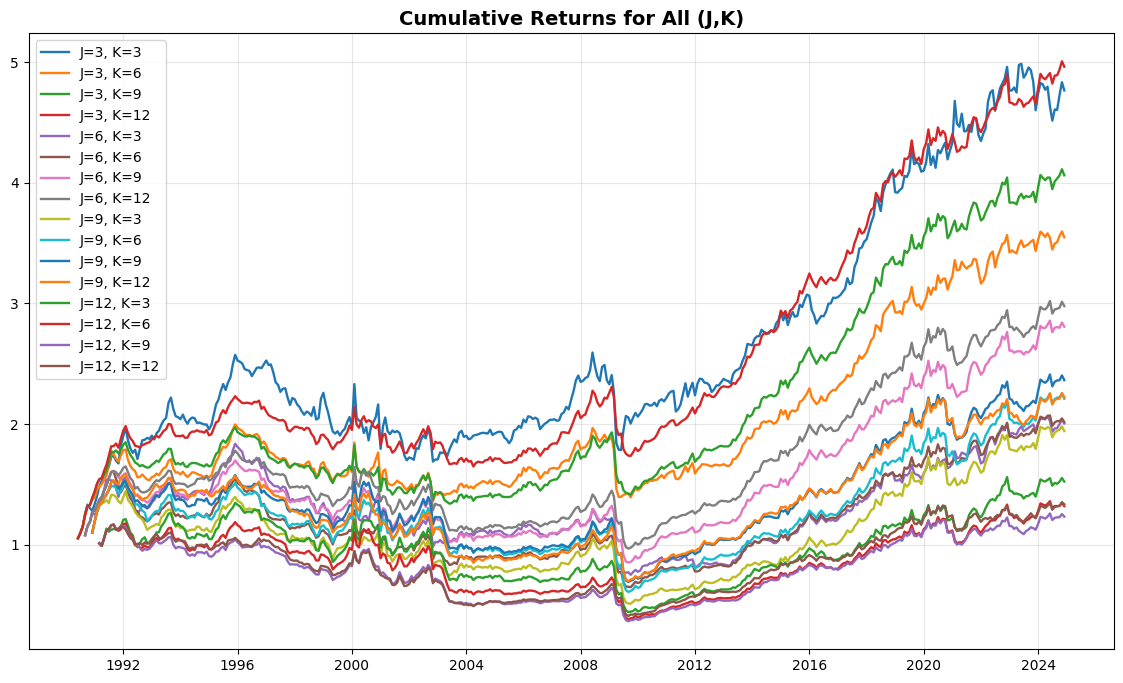

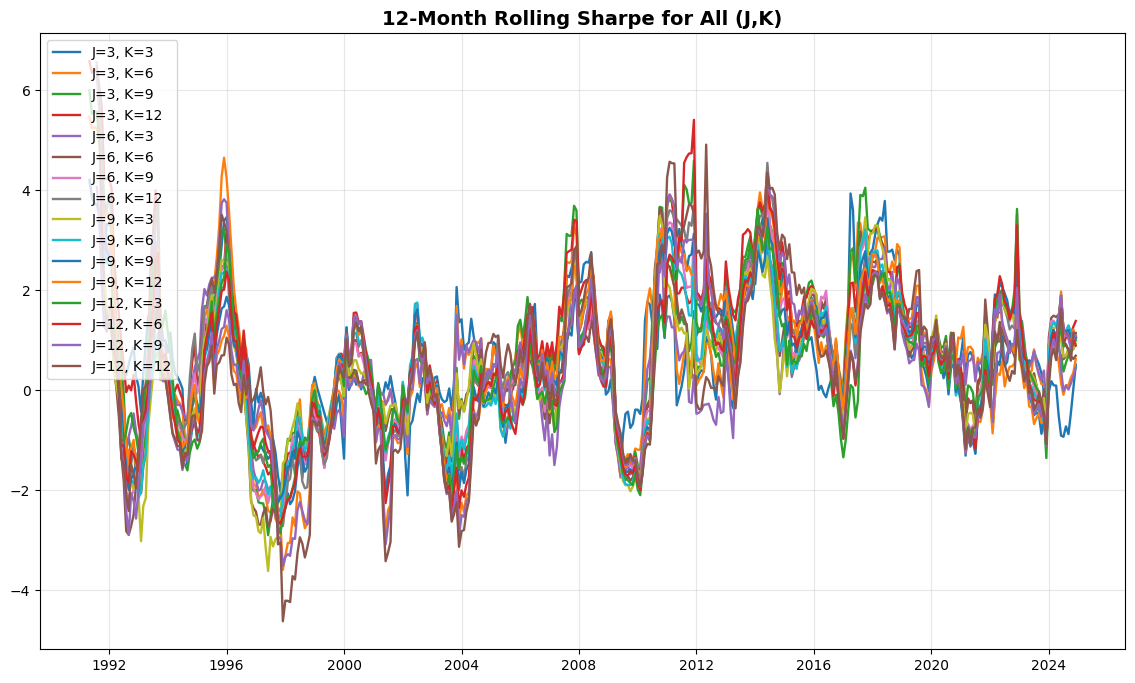

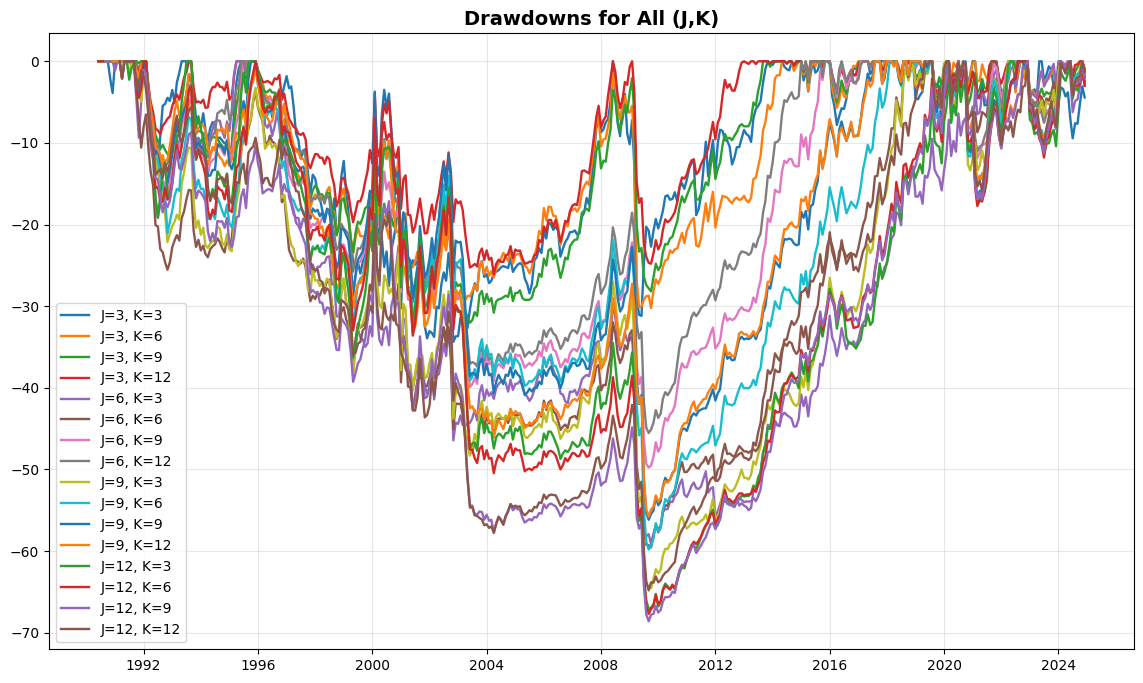

In [62]:
def plot_metric(metric='cumulative'):
    fig, ax = plt.subplots(figsize=(14, 8))

    for (J,K), rets in results_grid.items():
        label = f"J={J}, K={K}"
        
        if metric == 'cumulative':
            series = (1 + rets).cumprod()
            ax.plot(series.index, series, label=label, linewidth=1.7)
        
        elif metric == 'sharpe':
            rolling_mean = rets.rolling(12).mean() * 12
            rolling_vol = rets.rolling(12).std() * np.sqrt(12)
            rolling_sharpe = rolling_mean / rolling_vol
            ax.plot(rolling_sharpe.index, rolling_sharpe, 
                    label=label, linewidth=1.7)
        
        elif metric == 'drawdown':
            cum = (1 + rets).cumprod()
            dd = (cum - cum.expanding().max()) / cum.expanding().max()
            ax.plot(dd.index, dd*100, label=label, linewidth=1.7)

    titles = {
        'cumulative': 'Cumulative Returns for All (J,K)',
        'sharpe': '12-Month Rolling Sharpe for All (J,K)',
        'drawdown': 'Drawdowns for All (J,K)',
    }
    
    ax.set_title(titles[metric], fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()


# Plot results
plot_metric('cumulative')
plot_metric('sharpe')
plot_metric('drawdown')


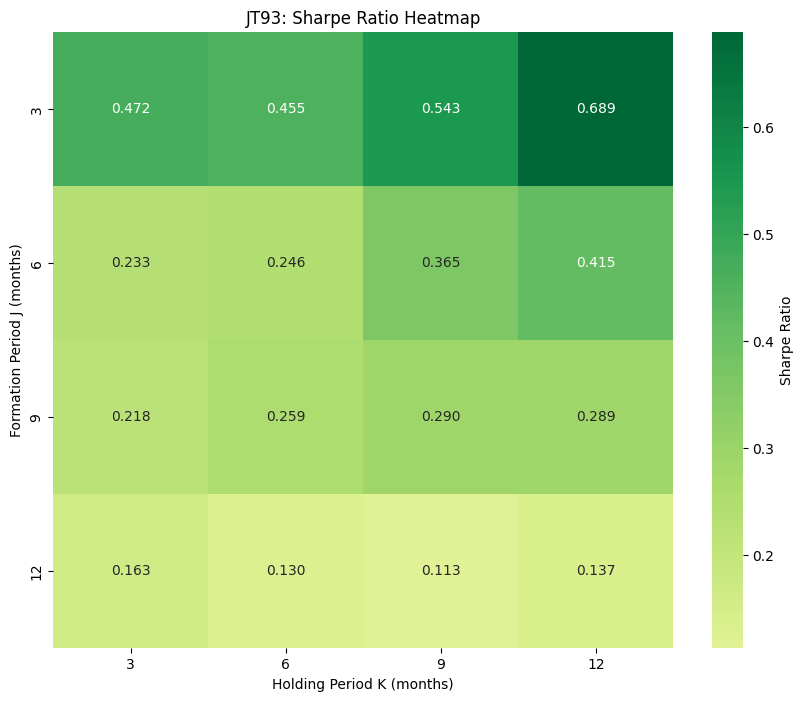

In [60]:
# heatmap of Sharpe ratios
sharpe_matrix = []

for J in J_values:
    row = []
    for K in K_values:
        rets = results_grid[(J,K)]
        ann_ret = rets.mean()*12
        ann_vol = rets.std()*np.sqrt(12)
        sharpe = ann_ret/ann_vol if ann_vol>0 else 0
        row.append(sharpe)
    sharpe_matrix.append(row)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pd.DataFrame(sharpe_matrix, index=J_values, columns=K_values),
            annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            cbar_kws={'label':'Sharpe Ratio'}, ax=ax)
ax.set_xlabel("Holding Period K (months)")
ax.set_ylabel("Formation Period J (months)")
ax.set_title("JT93: Sharpe Ratio Heatmap")
plt.show()
